In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib
import numpy as np

In [2]:
df = pd.read_parquet("/content/task_a_trial.parquet")

# View of data

In [3]:
df.head()

,code,generator,label,language
991293,#include <iostream>\n#include <string>\n#inclu...,microsoft/Phi-3-medium-4k-instruct,0,C++
1044782,#include <bits/stdc++.h>\n\n\n\n// #include <e...,Human,1,C++
1078925,class node:\n value = 0\n index = -1\n ...,ibm-granite/granite-8b-code-base-4k,0,Python
1574569,"class node:\n\n\tdef __init__(self, val):\n\t\...",Human,1,Python
707752,import java.util.*;\n\nclass FindElements {\n ...,meta-llama/Llama-3.1-8B-Instruct,0,Java


# Size of data
we have 10000 observations and only 4 features.

**Code**

**Generator**

**Label**

**Language**

In [4]:
df.shape

(10000, 4)

# *Data is balanced*

In [5]:
df.groupby("label").count()

,code,generator,language
label,,,
0,4979,4979,4979
1,5021,5021,5021


AI data was generaated by 61 different LLMs

In [6]:
df.groupby("generator").count().sort_values(by="label", ascending=False)

,code,label,language
generator,,,
Human,5021,5021,5021
meta-llama/Llama-3.3-70B-Instruct,372,372,372
Qwen/Qwen2.5-Coder-1.5B-Instruct,333,333,333
codellama/CodeLlama-70b-Instruct-hf,316,316,316
Qwen/Qwen2.5-Coder-32B-Instruct,310,310,310
...,...,...,...
meta-llama/Llama-3.2-11B-Vision-Instruct,2,2,2
gemini-2.5-flash-preview-05-20,1,1,1
gemini-2.0-flash-lite,1,1,1


In [7]:
df.groupby("language").count().sort_values(by="label", ascending=False)

,code,generator,label
language,,,
Python,7104,7104,7104
C++,1778,1778,1778
Java,1118,1118,1118


# The code in the dataset is written in python, which prevails, and then there are the C++ and java.

In [8]:
df["length"] = df["code"].apply(len)

In [9]:
df["length"]

,length
991293,607
1044782,2700
1078925,1057
1574569,493
707752,419
...,...
987602,266
770909,1951
1546337,842
1090338,2619


Lets add new features. Length of the string

In [10]:
df["strings_number"] = df["code"].apply(lambda x: len(x.split("\n")))
df['strings_number']

,strings_number
991293,31
1044782,237
1078925,52
1574569,33
707752,20
...,...
987602,13
770909,92
1546337,23
1090338,117


Number of strings in code

In [11]:
df["code"].iloc[9]

'class Solution {\n    public int countValidWords(String sentence) {\n        // edge case\n        if (sentence == null || sentence.trim().equals("")) return 0;\n        \n        int count = 0;\n        for (String token : sentence.split("\\\\s+")) {\n            count += isValidWord(token);\n        }\n        return count;\n    }\n    \n    private int isValidWord(String token) {\n        // trim leading and trailing whitespace\n        token = token.trim();\n        \n        // split by hyphen and punctuation mark\n        String[] parts = token.split("[,-.!]");\n        \n        // check if the token has only lowercase letters\n        for (String part : parts) {\n            if (!part.matches("[a-z]+")) return 0;\n        }\n        \n        // count the number of hyphens\n        int hyphenCount = 0;\n        for (String part : parts) {\n            if (part.matches("-")) hyphenCount++;\n        }\n        \n        // check if there is only one hyphen\n        if (hyphenCou

Check random code structure

In [12]:
def count_comments(row):
    code = row["code"]
    lang = row["language"]

    count = 0

    if lang == "Python":
        count += code.count("#")
        count += code.count('"""') // 2

    elif lang in ["C++", "Java"]:
        count += code.count("//")
        count += code.count("/*")

    return count

df["comments_number"] = df.apply(count_comments, axis=1)

print(df[["language", "code", "comments_number"]].head())


        language                                               code  \
991293       C++  #include <iostream>\n#include <string>\n#inclu...   
1044782      C++  #include <bits/stdc++.h>\n\n\n\n// #include <e...   
1078925   Python  class node:\n    value = 0\n    index = -1\n  ...   
1574569   Python  class node:\n\n\tdef __init__(self, val):\n\t\...   
707752      Java  import java.util.*;\n\nclass FindElements {\n ...   

         comments_number  
991293                 0  
1044782               12  
1078925                0  
1574569                0  
707752                 0  


Comments number for per code

In [13]:
df["density_of_string"] = df["length"] / df["strings_number"]
df["density_of_string"]

,density_of_string
991293,19.580645
1044782,11.392405
1078925,20.326923
1574569,14.939394
707752,20.950000
...,...
987602,20.461538
770909,21.206522
1546337,36.608696
1090338,22.384615


String density is defined as the length divided by the number of strings

/tmp/ipython-input-3602176724.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([human_length,ai_length],labels = ["Human","AI"])


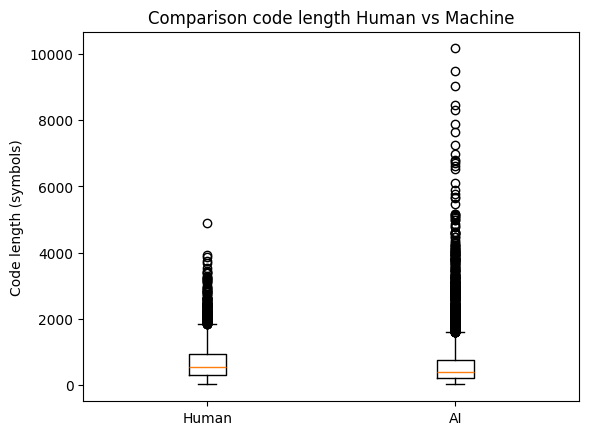

In [14]:

human_length = df[df["label"] == 0]["length"]
ai_length = df[df["label"] == 1]["length"]
plt.boxplot([human_length,ai_length],labels = ["Human","AI"])
plt.ylabel("Code length (symbols)")
plt.title("Comparison code length Human vs Machine")
plt.show()

# It can be seen from the sideplots that 4000 lines have been released, which is already 100% AI code. And the central values in the AI code are lower than in humans.

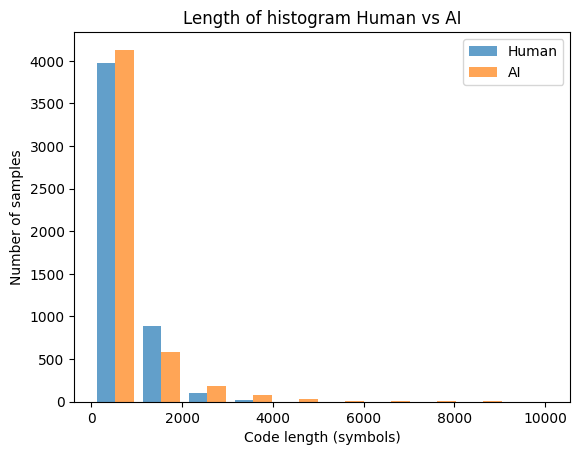

In [15]:
plt.hist([human_length,ai_length],label=["Human","AI"],bins = 10,alpha=0.7)
plt.xlabel("Code length (symbols)")
plt.ylabel("Number of samples")
plt.title("Length of histogram Human vs AI")
plt.legend()
plt.show()

One more plot for histogram

In [16]:
df["length_to_comms"] = np.where(
    df["comments_number"] == 0,
    df["length"],
    df["length"] / df["comments_number"]
)

The ratio of length to comments_number

In [17]:
df.head()

,code,generator,label,language,length,strings_number,comments_number,density_of_string,length_to_comms
991293,#include <iostream>\n#include <string>\n#inclu...,microsoft/Phi-3-medium-4k-instruct,0,C++,607,31,0,19.580645,607.0
1044782,#include <bits/stdc++.h>\n\n\n\n// #include <e...,Human,1,C++,2700,237,12,11.392405,225.0
1078925,class node:\n value = 0\n index = -1\n ...,ibm-granite/granite-8b-code-base-4k,0,Python,1057,52,0,20.326923,1057.0
1574569,"class node:\n\n\tdef __init__(self, val):\n\t\...",Human,1,Python,493,33,0,14.939394,493.0
707752,import java.util.*;\n\nclass FindElements {\n ...,meta-llama/Llama-3.1-8B-Instruct,0,Java,419,20,0,20.950000,419.0


# Overview created new features

In [18]:
def simplify_generator(x):
    if "/" in x:
        parts = x.split("/")
        if len(parts) > 1:
            return parts[1].split("-")[0]
    return x

df["generator_simple"] = df["generator"].apply(simplify_generator)


The creator of the company

In [19]:
ai_df= df[["code","language","generator_simple"]].groupby(["language","generator_simple"]).count()
ai_df

code
language generator_simple                    
C++      CodeLlama                        158
         DeepSeek                           2
         Devstral                           3
         GPT-4o                            14
         Human                            887
         Llama                            161
         Meta                               4
         Mistral                            3
         Phi                               98
         Qwen2.5                          248
         Yi                                75
         codegemma                         10
         deepseek                          48
         gemini-1.5-flash                   1
         gemini-2.0-flash                   4
         gemini-2.5-flash-preview-05-20     1
         gemma                              5
         gemma-3n-e4b-it                    1
         granite                           13
         phi                               11
         starcoder                         10
         starcoder2                        21
Java     CodeLlama                         88
         GPT-4o                             1
         Human                            559
         Llama                             99
         Phi                               59
         Qwen2.5                          169
         Yi                                56
         codegemma                          7
         deepseek                          46
         gemma                              1
         granite                           12
         phi                                2
         starcoder                          5
         starcoder2                        14
Python   CodeLlama                        417
         DeepSeek                           2
         Devstral                           1
         GPT-4o                            10
         Human                           3575
         Llama                            619
         Meta                               3
         Mistral                            5
         Mixtral                            1
         Phi                              562
         Qwen2.5                          746
         Yi                               301
         codegemma                        109
         deepseek                         187
         gemini-1.5-flash                   1
         gemini-2.0-flash-lite              1
         gemma                              5
         gemma-3n-e4b-it                    1
         granite                          172
         phi                              138
         starcoder                        111
         starcoder2                       137

Which LLMs wrote in which languages.

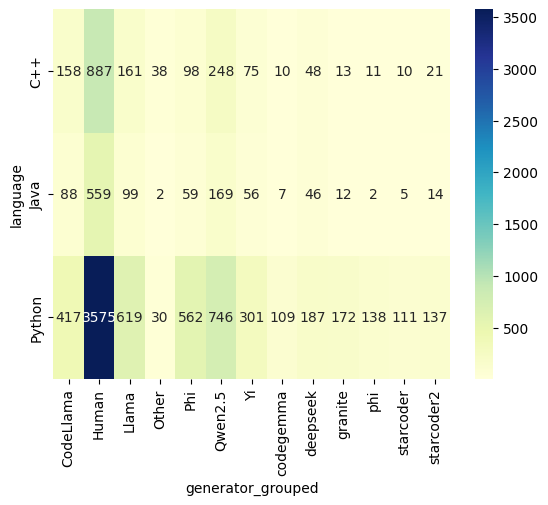

In [20]:
threshold = 50
counts = df["generator_simple"].value_counts()
rare_generators = counts[counts < threshold].index

df["generator_grouped"] = df["generator_simple"].replace(rare_generators, "Other")

heatmap_data = df.groupby(["language", "generator_grouped"]).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.show()


This heatmap illustrates the distribution of code generators(that have more than 50 samples) for each programming language

In [21]:
human_samples = df[df["label"] == 0]["code"].sample(10, random_state=42)

print("===== 10 случайных Human-кодов =====")
for i, code in enumerate(human_samples, 1):
    print(f"\nHuman #{i}:\n{code}")

===== 10 случайных Human-кодов =====

Human #1:
def smallest_multiple(n):
    if n % 2 == 0:
        return n
    else:
        return n * 2


Human #2:
	n,k=list(map(int,input().split()))
	s=input()
	l,r=0,0
	m,a=['()'*int((n)/2)]
	i2=0
	for _ in range(k-1):
		a.append(l,'()',' * '*(i2+1))
		i2+=1
	

Human #3:
assert 1 <= n <= 1000
num = input()
assert len(num) == n
target = input()
assert len(target) == n


# 1. 예제 입력
# 2. while문 을 이용해BACK: front가 target과 같으면 break (count - 1, count - 2, count - 3...)
# 3. 

"""
7개 과제를 통하여 순서를 구현 하는 것과, 순서를 배열에서 뽑는 것이 다르다.
순서를 구현한다면, end는 배열 끝에 있다.
순서를 뽑는다면 end라고 하여 backward로 n만큼 이동해 있다. 
"""
n = int(input())
num = list(input())
move = input()
high = [] # 6,5,4,3,2,1,0 오름차순
val = [] # 배열을 만들고 큰수가 마지막으로 오도록
hashmap = [] # num과 move을 내림차순으로 mp해둔다. 
# key 값:ć인 duck 값:nomal
key = 0
value = 0

print("move " + move)
for i in move:
    if i == 4 or i == 0 or i == 6:
        high.append(i)
print("high " + str(high))
for i in num:
    if i in high:
        va

10 human codes for example

In [22]:
ai_df = df[df["label"] == 1]

unique_generators = df["generator_simple"].unique()

print("\n===== 10 случайных AI-кодов =====")
ai_samples = []
for gen in unique_generators[:10]:
    sample = df[df["generator_simple"] == gen]["code"].sample(1, random_state=42).iloc[0]
    ai_samples.append((gen, sample))

for i, (gen, code) in enumerate(ai_samples, 1):
    print(f"\nAI #{i} (Generator: {gen}):\n{code}")


===== 10 случайных AI-кодов =====

AI #1 (Generator: Phi):
import itertools

# Function to calculate the cost of a permutation
def permutation_cost(perm, d):
    cost = 0
    for i in range(len(perm) - 1):
        if perm[i] * d == perm[i + 1]:
            cost += 1
    return cost

# Main logic to find the maximum cost permutation
def find_max_cost_permutation(n):
    # Try all possible values of d from 1 to n
    for d in range(1, n + 1):
        max_cost = 0
        max_cost_perm = []
        for perm in itertools.permutations(range(1, n + 1)):
            cost = permutation_cost(perm, d)
            if cost > max_cost:
                max_cost = cost
                max_cost_perm = perm
        # Print the result for this value of d
        print(d)
        print(' '.join(map(str, max_cost_perm)))

# Main function to read input and process each case
def main():
    t = int(input().strip())
    for _ in range(t):
        n = int(input().strip())
        find_max_cost_permutation(n)

10 AI codes for example

In [23]:
def top_ngrams(codes, ngram_range=(4,6), top=10):
    """
    Returns the top n-grams from the list of codes.
    ngram_range=(1,2) — unigrams and bigrams
    """
    vectorizer = CountVectorizer(token_pattern=r"\S+", ngram_range=ngram_range)
    X = vectorizer.fit_transform(codes)
    sums = X.sum(axis=0)
    counts = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    counts = sorted(counts, key=lambda x: x[1], reverse=True)
    return counts[:top]

# Human-codes
human_codes = df[df["label"] == 0]["code"]
top_human = top_ngrams(human_codes, ngram_range=(1,2), top=10)

print("===== Top n-grams of Human Code =====")
for gram, count in top_human:
    print(f"{gram}: {count}")

# AI-codes
ai_codes = df[df["label"] == 1]["code"]
top_ai = top_ngrams(ai_codes, ngram_range=(1,2), top=10)

print("\n===== Top n-grams of AI code =====")
for gram, count in top_ai:
    print(f"{gram}: {count}")


===== Top n-grams of Human Code =====
=: 31217
if: 10827
for: 10649
}: 9548
{: 9061
in: 8743
#: 8531
i: 8024
return: 7525
+: 7201

===== Top n-grams of AI code =====
=: 38630
}: 12734
{: 10497
if: 10183
for: 10127
i: 10043
+: 9156
in: 8604
-: 8079
int: 7393


In [24]:
df.columns

Index(['code', 'generator', 'label', 'language', 'length', 'strings_number',
       'comments_number', 'density_of_string', 'length_to_comms',
       'generator_simple', 'generator_grouped'],
      dtype='object')

In [25]:
df.head()

,code,generator,label,language,length,strings_number,comments_number,density_of_string,length_to_comms,generator_simple,generator_grouped
991293,#include <iostream>\n#include <string>\n#inclu...,microsoft/Phi-3-medium-4k-instruct,0,C++,607,31,0,19.580645,607.0,Phi,Phi
1044782,#include <bits/stdc++.h>\n\n\n\n// #include <e...,Human,1,C++,2700,237,12,11.392405,225.0,Human,Human
1078925,class node:\n value = 0\n index = -1\n ...,ibm-granite/granite-8b-code-base-4k,0,Python,1057,52,0,20.326923,1057.0,granite,granite
1574569,"class node:\n\n\tdef __init__(self, val):\n\t\...",Human,1,Python,493,33,0,14.939394,493.0,Human,Human
707752,import java.util.*;\n\nclass FindElements {\n ...,meta-llama/Llama-3.1-8B-Instruct,0,Java,419,20,0,20.950000,419.0,Llama,Llama


In [26]:
num_features = [
    "length",
    "strings_number",
    "comments_number",
    "density_of_string",
    "length_to_comms"
]
cat_features = ["language"]

X = df[num_features + cat_features]
y = df["label"]

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

Dividing our features to numerical and categorical features. And data split data to test and train

In [28]:
preprocessor = ColumnTransformer(transformers=[
    ('num',StandardScaler(),num_features),
    ('cat',OneHotEncoder(),cat_features)
]
)
logreg = Pipeline(steps=[
    ("prep",preprocessor),
    ('model',LogisticRegression(max_iter=1000))
])
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test,y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))

Logistic Regression
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       996
           1       0.66      0.72      0.69      1004

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000

Macro F1: 0.6720788695445506


Trying a logistic regression. Result is not satisfactory. I think it doesnt fully understand the data

In [29]:
rf = Pipeline(steps=[
    ("prep",preprocessor),
    ("model",RandomForestClassifier(n_estimators = 300,
     max_depth =10,
    random_state = 42,
     n_jobs=1))])
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test,y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))

Random Forest
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       996
           1       0.75      0.72      0.74      1004

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Macro F1: 0.739915732697394


Randomforest is a little bit better, but we need better. Ok,lets try another. It doesnt see patterns and style of code

In [30]:
xgb = Pipeline(steps=[
    ("prep",preprocessor),
    ("model",XGBClassifier(
        n_estimators=400,
        max_depth = 5,
        subsample= 0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42,
        n_jobs=-1
    ))])
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print("XGBoost")
print(classification_report(y_test,y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))

XGBoost
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       996
           1       0.69      0.75      0.72      1004

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.70      2000
weighted avg       0.71      0.71      0.70      2000

Macro F1: 0.7049416758861957


XGboost also didnt see pattern.And yes, of course, we need to take the style into account somehow.

In [31]:
rf_best = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=600,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features="sqrt",
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)

print(classification_report(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))


              precision    recall  f1-score   support

           0       0.73      0.75      0.74       996
           1       0.75      0.72      0.73      1004

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Macro F1: 0.7374589779653071


Some experiments with RF didnt help. So we need something else

In [32]:
X_test_copy = X_test.copy()
X_test_copy["true"] = y_test.values
X_test_copy["pred"] = y_pred

false_pos = X_test_copy[(X_test_copy["true"] == 0) & (X_test_copy["pred"] == 1)]
false_neg = X_test_copy[(X_test_copy["true"] == 1) & (X_test_copy["pred"] == 0)]

print("False Positive (Human → AI):", len(false_pos))
print("False Negative (AI → Human):", len(false_neg))


False Positive (Human → AI): 246
False Negative (AI → Human): 279


False labels are common for each class

In [33]:
char_vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=5,
    max_features=100_000
)


In [35]:
X_tab = df[num_features + cat_features]
X_text = df["code"]
y = df["label"]


Create dataset for numerical and catogorical features

In [36]:
X_tab_train, X_tab_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_tab, X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Splitting it to train and test

In [37]:
char_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(4,6),
        min_df=5,
        max_features=100_000
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

char_model.fit(X_text_train, y_train)

y_pred_char = char_model.predict(X_text_test)

print("Char n-gram Macro F1:",
      f1_score(y_test, y_pred_char, average="macro"))


Char n-gram Macro F1: 0.8659290764814587


Char modek gives way better macro f1 metric. It gets individual parts and style

In [38]:
rf.fit(X_tab_train, y_train)
y_pred_rf = rf.predict(X_tab_test)


In [39]:
print("=== RF (tabular) ===")
print(classification_report(y_test, y_pred_rf))

print("=== Char n-grams ===")
print(classification_report(y_test, y_pred_char))


=== RF (tabular) ===
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       996
           1       0.75      0.72      0.74      1004

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

=== Char n-grams ===
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       996
           1       0.85      0.89      0.87      1004

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In the comparison we see how style is more informative than just numerical data

In [40]:
proba_rf = rf.predict_proba(X_tab_test)[:, 1]
proba_char = char_model.predict_proba(X_text_test)[:, 1]

final_proba = 0.5 * proba_rf + 0.5 * proba_char
y_pred_final = (final_proba > 0.5).astype(int)

print("Ensemble Macro F1:",
      f1_score(y_test, y_pred_final, average="macro"))


Ensemble Macro F1: 0.8499338208149794


Ensemble RandomForest with tabular data and Logistic regression with n grams. Result is a little worse. But i think it will be more stable on real data, because we take into account both the style and numerical features

In [41]:
joblib.dump(char_model, "char_model.joblib")


['char_model.joblib']

Save our model for deploying

In [42]:
X = df[[
    "code",
    "length",
    "strings_number",
    "comments_number",
    "density_of_string",
    "length_to_comms"
]]

y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [43]:
text_col = "code"
num_cols = [
    "length",
    "strings_number",
    "comments_number",
    "density_of_string",
    "length_to_comms"
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "char",
            TfidfVectorizer(
                analyzer="char",
                ngram_range=(4,6),
                min_df=5,
                max_features=100_000
            ),
            text_col
        ),
        (
            "num",
            StandardScaler(),
            num_cols
        )
    ],
    remainder="drop"
)

hybrid_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        n_jobs=-1
    ))
])


In [44]:
hybrid_model.fit(X_train, y_train)

y_pred_hybrid = hybrid_model.predict(X_test)

print(
    "Hybrid Macro F1:",
    f1_score(y_test, y_pred_hybrid, average="macro")
)


Hybrid Macro F1: 0.8684144364873259


In [45]:
joblib.dump(hybrid_model, "hybrid_model.joblib")

['hybrid_model.joblib']

After testing on real data, char model has unstable classification ability, and It was decided to make a hybrid logistic regression model. It was much better stable